In [1]:
import numpy as np

# Matrix Product State Generative Model

## Prep datasets

In [2]:
# parse text files
with open('names/yob2022.txt', 'r') as f:
    female_names = []
    male_names = []
    female_counts = []
    male_counts = []
    vocabulary = set()
    max_length = 0
    for line in f:
        name, gender, count = line.split(',')
        name = name.lower()
        count = int(count)
        max_length = max(max_length, len(name))
        if gender == 'F':
            female_names.append(name)
            female_counts.append(count)
            for i in range(len(name)):
                vocabulary.add(name[i])
        elif gender == 'M':
            male_names.append(name)
            male_counts.append(count)
            for i in range(len(name)):
                vocabulary.add(name[i])
        else:
            print(f'Name {name} with gender {gender} is not counted')

female_counts = np.array(female_counts)
male_counts = np.array(male_counts)

for i, name in enumerate(female_names):
    female_names[i] = name.ljust(max_length, '_')
for i, name in enumerate(male_names):
    male_names[i] = name.ljust(max_length, '_')
vocabulary.add('_')

vocabulary = sorted(list(vocabulary))
vocab_size = len(vocabulary)

# tokenize
map_char_to_int = {char: i for i, char in enumerate(vocabulary)}
female_tokens = np.array([[map_char_to_int[char] for char in name] for name in female_names])
male_tokens = np.array([[map_char_to_int[char] for char in name] for name in male_names])

## Initialize MPS model

In [226]:
from matrix_product_state import MatrixProductState


# initialize MPS
num_tensors = max_length
site_dims = [vocab_size]*max_length
mps = MatrixProductState(max_length, site_dims)


# test train split
test_frac = 0.2
num_points = female_tokens.shape[0]
inds = np.random.permutation(female_tokens.shape[0])
inds_train = inds[int(test_frac*num_points):]
inds_test = inds[:int(test_frac*num_points)]

# sample training data
n_train = 10000
probs = female_counts[inds_train]/np.sum(female_counts[inds_train])
inds = np.random.choice(inds_train, p=probs, size=n_train)
X_train = female_tokens[inds]

# sample test data
n_test = 1000
probs = female_counts[inds_test]/np.sum(female_counts[inds_test])
inds = np.random.choice(inds_test, p=probs, size=n_test)
X_test = female_tokens[inds]

# load data
mps.load_data(X_train, dataset_name='train')
mps.load_data(X_test, dataset_name='test')


Play around with model parameters by setting the attributes `mps.cutoff` and `mps.max_rank`

In [227]:
mps.cutoff = 1e-3
mps.max_rank = 15

## Train

Play around with training parameters by setting the attributes `mps.batch_size` and `mps.learning_rate`

In [229]:
mps.batch_size = 10000
mps.learning_rate = 1e-6

mps.verbose = 1
mps.train(num_sweeps=50)

Finished sweep 0. Sweep direction: left
Ranks: [15, 15, 15, 15, 15, 15, 15, 15, 7, 3, 2, 2, 1, 1]
Losses: {'train': 10.974141803066843, 'test': 15.385003965887288}
Finished sweep 1. Sweep direction: right
Ranks: [15, 15, 15, 15, 15, 15, 15, 15, 7, 3, 2, 2, 1, 1]
Losses: {'train': 10.967709042689243, 'test': 15.389053952791581}
Finished sweep 2. Sweep direction: left
Ranks: [15, 15, 15, 15, 15, 15, 15, 15, 7, 3, 2, 2, 1, 1]
Losses: {'train': 10.961578763730172, 'test': 15.381724282157043}
Finished sweep 3. Sweep direction: right
Ranks: [15, 15, 15, 15, 15, 15, 15, 15, 7, 3, 2, 2, 1, 1]
Losses: {'train': 10.955543522340415, 'test': 15.373177553206162}
Finished sweep 4. Sweep direction: left
Ranks: [15, 15, 15, 15, 15, 15, 15, 15, 7, 3, 2, 2, 1, 1]
Losses: {'train': 10.949696759761533, 'test': 15.358546494760027}
Finished sweep 5. Sweep direction: right
Ranks: [15, 15, 15, 15, 15, 15, 15, 15, 7, 3, 2, 2, 1, 1]
Losses: {'train': 10.94381290385149, 'test': 15.351486224870143}
Finished sweep

Plot losses

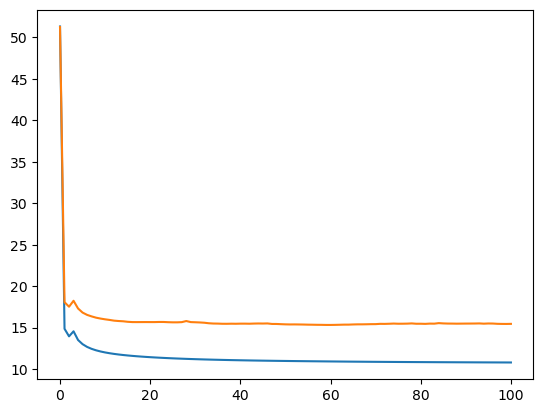

In [230]:
import matplotlib.pyplot as plt

# plt.plot(np.log(np.arange(len(mps.losses['train']))), np.log(mps.losses['train']))
# plt.plot(np.log(np.arange(len(mps.losses['test']))), np.log(mps.losses['test']))
plt.plot(mps.losses['train'])
plt.plot(mps.losses['test'])
plt.show()

## Sample

In [231]:
# sample tokens from model
samples = mps.sample(num_samples=1000)

# change from tokens back to characters
def untokenize(tokens):
    split_names = np.array(vocabulary)[tokens]
    names = []
    for name in split_names:
        names.append(''.join(name))
    return names

sampled_names = untokenize(samples)


Check quality

In [232]:

female_name_set = set(female_names)
train_name_set = set(untokenize(X_train))
not_in_training = []
not_in_dataset = []
for name in sampled_names:
    if name not in female_name_set:
        not_in_dataset.append(name)
    if name not in train_name_set:
        not_in_training.append(name)

num_samples = samples.shape[0]
print(f'{len(not_in_training)}/{num_samples} names not in training data')
print(f'{len(not_in_dataset)}/{num_samples} names not in full dataset')

print('\nSome names not in the training dataset:')
random_names = np.random.choice(not_in_training, 10, replace=False)
for name in random_names:
    print(f'\t{name}')

print('\nSome names not in the full dataset:')
random_names = np.random.choice(not_in_dataset, 10, replace=False)
for name in random_names:
    print(f'\t{name}')

851/1000 names not in training data
778/1000 names not in full dataset

Some names not in the training dataset:
	alisy__________
	zami___________
	sakth__________
	ratemw_________
	inereni________
	kaes___________
	allhia_________
	ausarela_______
	rilper_________
	fipana_________

Some names not in the full dataset:
	wiolyn_________
	evecelle_______
	oauyn__________
	elear__________
	channd_________
	kalephia_______
	rolce__________
	ryapelia_______
	marelia________
	ivabey_________
